In [30]:
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import make_scorer, fbeta_score
import numpy as np
import matplotlib.pyplot as plt

from StackedModelFeatureImportance import *

In [6]:
# 1. Load the dataset
df = pd.read_csv("data/mushroom2.csv")

# 2. Fill the real-missing values with "?"
df = df.fillna("?")

# 3. Drop useless columns identified from EDA (gill-attachment, veil-type)
df = df.drop(columns=["veil-type"])

# 4. Separate features and target
X = df.drop("class", axis=1)
y = df["class"]

# 5. Perform 80–20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y)

### Stack Ensemble, Find Final F2 Score

In [7]:
# all features are categorical
categorical_features = X_train.columns.tolist()

ohe_stack = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocess_stack = ColumnTransformer(
    transformers=[
        ("cat", ohe_stack, categorical_features)
    ]
)

In [14]:
# base models for stacking
base_estimators = [
    ("lr",  LogisticRegression(max_iter=2000, solver="lbfgs", n_jobs=-1)),
    ("lda", LinearDiscriminantAnalysis()),
    ("qda", QuadraticDiscriminantAnalysis()),
    ("knn", KNeighborsClassifier(
        n_neighbors=20,
        weights="distance",
        n_jobs=-1
    )),
    ("rf",  RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    )),
    ("gb",  GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=3,
        random_state=42)),
    ("svm", SVC(
        C=0.1, gamma=0.1, kernel = 'rbf',
        probability=True,
        class_weight="balanced",
        random_state=42
    )),
]

# final meta-learner
final_estimator = LogisticRegression(max_iter=1000)

# ----- Stack Ensemble -----
stack_clf = Pipeline(steps=[
    ("preprocess", preprocess_stack),
    ("stack", StackingClassifier(
        estimators=base_estimators,
        final_estimator=final_estimator,
        stack_method="predict_proba",  # pass probabilities to meta-learner
        n_jobs=-1
    ))
])

In [15]:
# fit on training data
stack_clf.fit(X_train, y_train)



/opt/anaconda3/envs/242A_HW1/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/opt/anaconda3/envs/242A_HW1/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/opt/anaconda3/envs/242A_HW1/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/opt/anaconda3/envs/242A_HW1/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param`

,steps,"[('preprocess', ...), ('stack', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [19]:
y_proba_svm = stack_clf.predict_proba(X_test)[:, 1]
threshold = 0.27
y_pred_svm = np.where(y_proba_svm >= threshold, "p", "e")

print("Stack Ensemble Accuracy:", accuracy_score(y_test, y_pred_svm))

cm_svm = confusion_matrix(y_test, y_pred_svm)
TN, FP, FN, TP = cm_svm.ravel()
TPR = TP / (TP + FN)
FNR = FN / (TP + FN)
FPR = FP / (FP + TN)
TNR = TN / (TN + FP)

print(f"\nTrue Positive Rate (TPR): {TPR:.4f}")
print(f"False Negative Rate (FNR): {FNR:.4f}")
print(f"False Positive Rate (FPR): {FPR:.4f}")
print(f"True Negative Rate (TNR): {TNR:.4f}")

print("\nStack Ensemble Confusion Matrix:")
print(cm_svm)

# Calculate F2 score
# ---- F2 SCORE HERE ----
F2 = fbeta_score(y_test, y_pred_svm, beta=2, pos_label="p")
print(f"\nF2 Score: {F2:.4f}")

Stack Ensemble Accuracy: 0.7045017314351674

True Positive Rate (TPR): 0.8904
False Negative Rate (FNR): 0.1096
False Positive Rate (FPR): 0.4462
True Negative Rate (TNR): 0.5538

Stack Ensemble Confusion Matrix:
[[1590 1281]
 [ 255 2072]]

F2 Score: 0.8183


### Get Feature Importance

In [21]:
features = X_train.columns 
print(features)

Index(['cap-shape', 'cap-surface', 'cap-color', 'ruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-color', 'ring-number', 'ring-type',
       'spore-print-color', 'population', 'habitat'],
      dtype='object')


FEATURE IMPORTANCE ANALYSIS FOR STACKING ENSEMBLE

[1/3] Calculating Permutation Importance...
Computing permutation importance (this may take a while)...

Top 10 Features by Permutation Importance:
                 feature  importance_mean  importance_std
                    odor         0.175221        0.003813
               gill-size         0.019738        0.003881
stalk-surface-above-ring         0.015621        0.002510
stalk-surface-below-ring         0.011312        0.002558
                  ruises         0.007426        0.002702
       spore-print-color         0.005329        0.002920
               ring-type         0.004848        0.002213
              population         0.003367        0.002772
             cap-surface         0.002270        0.001863
            gill-spacing         0.001520        0.002091


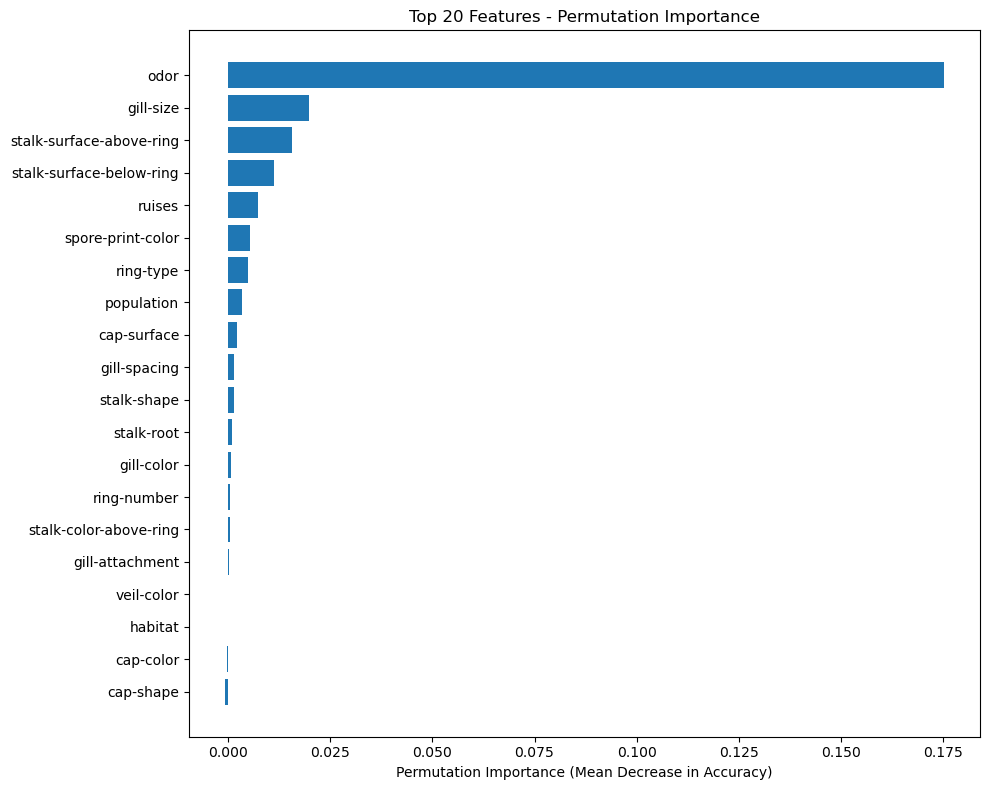


[2/3] Extracting Base Model Feature Importances...


TypeError: cannot unpack non-iterable LogisticRegression object

In [31]:
# After fitting your stack_clf
analyzer = StackedModelFeatureImportance(
    fitted_pipeline=stack_clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=features  # list of feature names
)

# Get everything at once
results = analyzer.generate_full_report(top_n=20)